In [1]:
import numpy as np
import pandas as pd

import strawb
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import scipy.ndimage
import random
import scipy.spatial
import cv2
import scipy.interpolate

import matplotlib.colors
import copy
import matplotlib.ticker
import matplotlib.patches

In [2]:
pd.__version__

'1.4.4'

In [3]:
w = 0.0138*398.3386

# Import Data

In [4]:
# DataFrame ueber mehrere Tage

cluster_temp_fname = 'TUMPMTSPECTROMETER001.gz'

if not os.path.exists(cluster_temp_fname):
    print("Doesn't exist")
else:
    image_cluster_db = strawb.sync_db_handler.ImageClusterDB(file_name=cluster_temp_fname)

In [5]:
# load DB
db = strawb.SyncDBHandler(file_name='Default')  # loads the db
db.load_onc_db_update(save_db=True)  # update the DB, could take some time if it has to load info. from ONC

100%|██████████| 9/9 [00:03<00:00,  2.96devices/s, i=TUMSTANDARDMODULE004] 
update synced form          0 to          0; delta:          0
0files [00:00, ?files/s]
0files [00:00, ?files/s]


/home/straw/Documents/strawb_package/src/strawb/sync_db_handler/sync_db_handler.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append(dataframe2add_diff)  # for newer pandas versions: concat = append


,archiveLocation,archivedDate,compression,dataProductCode,dateFrom,dateTo,deviceCode,fileSize,filename,modifyDate,path,uncompressedFileSize,outPath,fullPath,synced,h5_attrs,file_version
fullPath,,,,,,,,,,,,,,,,,
/home/straw/Documents/strawb_package/raw_module_data/tumstandardmodule004/2022_09/TUMSTANDARDMODULE004_20220912T000000.000Z-SDAQ-MODULE.hdf5,/NA_Archive_06,2022-09-13 01:01:05.045000+00:00,None,SMRD,2022-09-12 00:00:00+00:00,2022-09-12 23:59:59.999000+00:00,TUMSTANDARDMODULE004,2387509,TUMSTANDARDMODULE004_20220912T000000.000Z-SDAQ...,2022-09-13 01:01:05.148000+00:00,01/76/05,2387509,/home/straw/Documents/strawb_package/raw_modul...,/home/straw/Documents/strawb_package/raw_modul...,False,None,NaN
/home/straw/Documents/strawb_package/raw_module_data/tumstandardmodule004/2022_09/TUMSTANDARDMODULE004_20220913T000000.000Z-SDAQ-MODULE.hdf5,/NA_Archive_06,2022-09-14 01:01:06.373000+00:00,None,SMRD,2022-09-13 00:00:00+00:00,2022-09-13 23:59:59.999000+00:00,TUMSTANDARDMODULE004,2408227,TUMSTANDARDMODULE004_20220913T000000.000Z-SDAQ...,2022-09-14 01:01:06.498000+00:00,01/84/89,2408227,/home/straw/Documents/strawb_package/raw_modul...,/home/straw/Documents/strawb_package/raw_modul...,False,None,NaN
/home/straw/Documents/strawb_package/raw_module_data/tumstandardmodule001/2022_09/TUMSTANDARDMODULE001_20220912T000000.000Z-SDAQ-MODULE.hdf5,/NA_Archive_06,2022-09-13 01:16:26.395000+00:00,None,SMRD,2022-09-12 00:00:00+00:00,2022-09-12 23:59:59.999000+00:00,TUMSTANDARDMODULE001,2392799,TUMSTANDARDMODULE001_20220912T000000.000Z-SDAQ...,2022-09-13 01:16:26.492000+00:00,01/76/17,2392799,/home/straw/Documents/strawb_package/raw_modul...,/home/straw/Documents/strawb_package/raw_modul...,False,None,NaN
/home/straw/Documents/strawb_package/raw_module_data/tumstandardmodule001/2022_09/TUMSTANDARDMODULE001_20220912T000000.000Z.txt,/NA_Archive_06,2022-09-13 05:55:01.320000+00:00,gz,LF,2022-09-12 00:00:00+00:00,2022-09-13 00:00:00+00:00,TUMSTANDARDMODULE001,139631,TUMSTANDARDMODULE001_20220912T000000.000Z.txt,2022-09-13 05:55:01.428000+00:00,01/77/97,1467933,/home/straw/Documents/strawb_package/raw_modul...,/home/straw/Documents/strawb_package/raw_modul...,False,None,-2.0
/home/straw/Documents/strawb_package/raw_module_data/tumstandardmodule001/2022_09/TUMSTANDARDMODULE001_20220913T000000.000Z-SDAQ-MODULE.hdf5,/NA_Archive_06,2022-09-14 01:16:34.915000+00:00,None,SMRD,2022-09-13 00:00:00+00:00,2022-09-13 23:59:59.999000+00:00,TUMSTANDARDMODULE001,2367250,TUMSTANDARDMODULE001_20220913T000000.000Z-SDAQ...,2022-09-14 01:16:35.038000+00:00,01/85/01,2367250,/home/straw/Documents/strawb_package/raw_modul...,/home/straw/Documents/strawb_package/raw_modul...,False,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/home/straw/Documents/strawb_package/raw_module_data/tumpmtspectrometer001/2022_09/TUMPMTSPECTROMETER001_20220913T220000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_06,2022-09-14 01:39:07.048000+00:00,None,MSSCD,2022-09-13 22:00:00+00:00,2022-09-13 22:59:59.999000+00:00,TUMPMTSPECTROMETER001,50908057,TUMPMTSPECTROMETER001_20220913T220000.000Z-SDA...,2022-09-14 01:39:08.655000+00:00,01/85/16,50908057,/home/straw/Documents/strawb_package/raw_modul...,/home/straw/Documents/strawb_package/raw_modul...,False,None,NaN
/home/straw/Documents/strawb_package/raw_module_data/tumpmtspectrometer001/2022_09/TUMPMTSPECTROMETER001_20220913T230000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_06,2022-09-14 01:39:04.117000+00:00,None,MSSCD,2022-09-13 23:00:00+00:00,2022-09-13 23:59:59.999000+00:00,TUMPMTSPECTROMETER001,50907025,TUMPMTSPECTROMETER001_20220913T230000.000Z-SDA...,2022-09-14 01:39:05.845000+00:00,01/85/16,50907025,/home/straw/Documents/strawb_package/raw_modul...,/home/straw/Documents/strawb_package/raw_modul...,False,None,NaN
/home/straw/Documents/strawb_package/raw_module_data/tumpmtspectrometer001/2022_09/TUMPMTSPECTROMETER001_20220913T230000.000Z-SDAQ-PMTSPEC.hdf5,/NA_Archive_06,2022-09-14 01:39:05.875000+00:00,None,PMTSD,2022-09-13 23:0

In [6]:
mask = (db.dataframe.deviceCode == 'TUMPMTSPECTROMETER001') # that's the pmtspec module
mask &= (db.dataframe.dataProductCode =='MSSCD') # that's the camera data of the pmtspec module

## select the file for the biolumi event with a window of +- 5 hours
# timestamp = pd.Timestamp('2022-03-04T23:44:09', tz='UTC')  # gain = 30
timestamp = pd.Timestamp('2021-09-04T23:44:09', tz='UTC')  # gain = 50
mask &= db.dataframe.dateFrom >= timestamp - pd.Timedelta('5H')  # - 5 hours
mask &= db.dataframe.dateFrom <= timestamp + pd.Timedelta('5H')  # - 5 hours

### selected one file from the DB (it's the same as the file we selected above by hand)
db.dataframe[mask]

,archiveLocation,archivedDate,compression,dataProductCode,dateFrom,dateTo,deviceCode,fileSize,filename,modifyDate,...,file_end,file_id,file_start,following_file_id,name,previous_file_id,rollover_interval,run_end,run_start,write_period
fullPath,,,,,,,,,,,,,,,,,,,,,
/home/straw/Documents/strawb_package/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210904T190000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_04,2021-09-05 01:51:00.715000+00:00,None,MSSCD,2021-09-04 19:00:00+00:00,2021-09-04 19:59:59.999000+00:00,TUMPMTSPECTROMETER001,58047990,TUMPMTSPECTROMETER001_20210904T190000.000Z-SDA...,2021-09-05 01:51:02.164000+00:00,...,2021-09-04 19:59:59.999000072+00:00,1.357886e+19,2021-09-04 19:00:00+00:00,6.926671e+18,CAMERA,1.248829e+19,{'hours': 1},NaT,2021-08-14 21:50:37.159261942+00:00,121.0
/home/straw/Documents/strawb_package/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210904T200000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_04,2021-09-05 01:51:11.375000+00:00,None,MSSCD,2021-09-04 20:00:00+00:00,2021-09-04 20:59:59.999000+00:00,TUMPMTSPECTROMETER001,58230287,TUMPMTSPECTROMETER001_20210904T200000.000Z-SDA...,2021-09-05 01:51:15.677000+00:00,...,2021-09-04 20:59:59.999000072+00:00,6.926671e+18,2021-09-04 20:00:00+00:00,3.179034e+18,CAMERA,1.357886e+19,{'hours': 1},NaT,2021-08-14 21:50:37.159261942+00:00,121.0
/home/straw/Documents/strawb_package/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210904T210000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_04,2021-09-05 01:51:16.668000+00:00,None,MSSCD,2021-09-04 21:00:00+00:00,2021-09-04 21:59:59.999000+00:00,TUMPMTSPECTROMETER001,57914808,TUMPMTSPECTROMETER001_20210904T210000.000Z-SDA...,2021-09-05 01:51:18.432000+00:00,...,2021-09-04 21:59:59.999000072+00:00,3.179034e+18,2021-09-04 21:00:00+00:00,1.479619e+19,CAMERA,6.926671e+18,{'hours': 1},NaT,2021-08-14 21:50:37.159261942+00:00,121.0
/home/straw/Documents/strawb_package/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210904T220000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_04,2021-09-05 01:51:19.541000+00:00,None,MSSCD,2021-09-04 22:00:00+00:00,2021-09-04 22:59:59.999000+00:00,TUMPMTSPECTROMETER001,56598135,TUMPMTSPECTROMETER001_20210904T220000.000Z-SDA...,2021-09-05 01:51:21.507000+00:00,...,2021-09-04 22:59:59.999000072+00:00,1.479619e+19,2021-09-04 22:00:00+00:00,8.369819e+18,CAMERA,3.179034e+18,{'hours': 1},NaT,2021-08-14 21:50:37.159261942+00:00,121.0
/home/straw/Documents/strawb_package/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210904T230000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_04,2021-09-05 01:51:24.463000+00:00,None,MSSCD,2021-09-04 23:00:00+00:00,2021-09-04 23:59:59.999000+00:00,TUMPMTSPECTROMETER001,58043955,TUMPMTSPECTROMETER001_20210904T230000.000Z-SDA...,2021-09-05 01:51:26.475000+00:00,...,2021-09-04 23:59:59.999000072+00:00,8.369819e+18,2021-09-04 23:00:00+00:00,8.594007e+18,CAMERA,1.479619e+19,{'hours': 1},NaT,2021-08-14 21:50:37.159261942+00:00,121.0
/home/straw/Documents/strawb_package/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210905T000000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_04,2021-09-05 01:51:27.455000+00:00,None,MSSCD,2021-09-05 00:00:00+00:00,2021-09-05 00:59:59.999000+00:00,TUMPMTSPECTROMETER001,57888861,TUMPMTSPECTROMETER001_20210905T000000.000Z-SDA...,2021-09-05 01:51:29.458000+00:00,...,2021-09-05 00:59:59.999000072+00:00,8.594007e+18,2021-09-05 00:00:00+00:00,6.334646e+18,CAMERA,8.369819e+18,{'hours': 1},NaT,2021-08-14 21:50:37.159261942+00:00,121.0
/home/straw/Documents/strawb_package/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210905T010000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_04,2021-09-06 01:40:19.007000+00:00,None,MSSCD,2021-09-05 01:00:00+00:00,2021-09-05 01:59:59.999000+00:00,TUMPMTSPECTROMETER001,58105636,TUMPMTSPECTROMETER001_20210905T010000.000Z-SDA...,2021-09-06 01:40:20.942000+00:00,...,2021-09-05 01:59:59.999000072+00:00,6.334646e+18,2021-09-05 01:00:00+00:00,6.744

In [7]:
if not db.dataframe.synced[mask].all():
    db.update_db_and_load_files(
        db.dataframe[mask],
        output=True,  # print output to console
        download=True,  # download the files
        save_db=True,
    )  # update the DB

In [8]:
# select the Camera file(s) -> dataProductCode == 'MSSCD'
item = db.dataframe[mask & (db.dataframe.dataProductCode =='MSSCD')]

try: # if the pmtspec file is still open
    camera.file_handler.close()
except:
    pass
    
# generate a virtual hdf5 to combine the datasets if there are multiple files selected
if len(item) > 1:
    vhdf5 = strawb.VirtualHDF5('MSSCD_event_view.hdf5', item.fullPath.to_list())  
    file_name = vhdf5.file_name
else:
    file_name = item.fullPath[0]

# create an instance of the Camera
camera = strawb.Camera(file_name)

## ----------------------------------------------------------------------------------------------------------

# Modify Dataframe

In [9]:
df = image_cluster_db.dataframe[image_cluster_db.dataframe.label!=0]

In [10]:
limit = 20  # limit from plot
limit_max = 1e5  # limit from plot
parameter = 'n_pixel'

mask_para = df[parameter]  > limit
mask_para &= df[parameter]  < limit_max

In [11]:
df_i = df[mask_para]  # df with 20 < n_pixel < 1e5

### Field of View

In [194]:
with np.load('mounting_mask.npz') as f:
    mounting_cam = f['TUMPMTSPECTROMETER001.npy']

mounting_cam

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [196]:
import rasterio.features 
import shapely.geometry

# array with 1 if pixel is inside the FoV of the camera, else 0 as int32
im = np.where(mounting_cam == False, 0, 1).astype('int32')  


# get shapes and values of connected regions in array
shapes = rasterio.features.shapes(im) 

# get the polygon around each shape
polygons = [shapely.geometry.Polygon(shape[0]['coordinates'][0]) for shape in shapes if shape[1] == 1]


# get polygon with maximal area = FoV of the camera
pol = max(polygons, key=lambda a: a.area) 


cm = [shapely.geometry.Point(i,j) for i,j in zip(df_i.center_of_mass_y.astype('int32'), 
                                                 df_i.center_of_mass_x.astype('int32'))]
fov = [pol.contains(i) for i in cm]

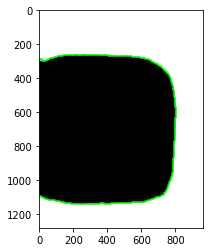

In [195]:
fig, ax = plt.subplots()
ax.imshow(mounting_cam, extent=[0, mounting_cam.shape[1], mounting_cam.shape[0], 0], cmap='Greys')
ax.plot(*pol.exterior.xy, color='lime')
#plt.xlim(50,100)
#plt.ylim(1140, 1100)

In [197]:
df_with_fov = df_i.copy()
df_with_fov.insert(5, 'field_of_view', fov, True)

df_fov = df_with_fov[df_with_fov.field_of_view == True]

In [198]:
df_fov

,mean_std_n,mean_std_start,mean_std_stop,label,time,field_of_view,center_of_mass_x,center_of_mass_y,center_of_pix_x,center_of_pix_y,...,n_pixel_blue,noise_blue,charge_with_noise_blue,sn_mean_deviation_blue,sn_mean_deviation_sigma_blue,angle,box_center_x,box_center_y,box_size_x,box_size_y
73,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,3180.0,2021-04-28 22:49:25.208035328+00:00,True,506.628745,546.630474,506.683544,547.303797,...,21.0,117188.545455,532112.0,19758.259740,4.023935,78.690071,506.000000,546.000061,32.555279,12.159200
74,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,3256.0,2021-04-28 22:49:25.208035328+00:00,True,517.618791,541.177465,517.400000,540.400000,...,6.0,28230.545455,137152.0,18153.575758,3.866049,75.256439,516.606262,538.103699,30.539196,4.886271
75,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,3289.0,2021-04-28 22:49:25.208035328+00:00,True,524.055583,538.266472,523.806452,537.612903,...,6.0,41284.545455,153792.0,18751.242424,3.807413,78.690071,523.769287,539.846252,42.361084,3.922322
76,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,3774.0,2021-04-28 22:49:25.208035328+00:00,True,604.271737,492.135053,604.240000,492.880000,...,2.0,10410.727273,44384.0,16986.636364,3.631974,86.987213,604.493042,492.868774,29.853416,8.567090
121,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,3112.0,2021-04-28 23:41:33.670472704+00:00,True,549.858733,210.402563,549.142857,208.476190,...,5.0,10859.272727,118688.0,21565.745455,4.782613,61.927513,548.129761,204.930817,20.705883,5.117647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485969,288,2022-07-30 00:00:00+00:00,2022-07-30 07:59:59.999999+00:00,878.0,2022-07-30 06:41:04.152556288+00:00,True,445.256376,639.834651,444.764706,640.549020,...,15.0,60271.777778,109920.0,3309.881481,5.554050,59.036240,444.073517,640.955933,6.859943,14.234381
486362,290,2022-07-30 16:00:00+00:00,2022-07-30 23:59:59.999999+00:00,1128.0,2022-07-30 17:32:25.001512704+00:00,True,560.057175,558.728410,560.285714,558.785714,...,10.0,39429.075862,62992.0,2356.292414,4.383335,32.005383,560.089905,557.056213,25.227951,4.875990
486634,287,2022-07-31 00:00:00+00:00,2022-07-31 07:59:59.999999+00:00,1010.0,2022-07-31 01:02:40.676560128+00:00,True,425.964518,95.859980,431.861284,82.894410,...,136.0,472986.871080,1581472.0,8150.625948,8.220321,27.050596,438.233765,72.917229,16.523571,99.766739
486666,287,2022-07-31 00:00:00+00:00,2022-07-31 07:59:59.999999+00:00,2178.0,2022-07-31 01:51:02.345961984+00:00,True,918.883400,35.138538,918.538462,33.820513,...,13.0,60384.836237,103792.0,3339.012597,5.199097,73.610458,917.090637,31.708614,20.033808,7.787791


### Housing

In [19]:
# array with 1 if pixel is inside the FoV of the camera, else 0 as int32
im2 = np.where(m == True, 0, 1).astype('int32')  


# get shapes and values of connected regions in array
shapes2 = rasterio.features.shapes(im2) 

# get the polygon around each shape
polygons2 = [shapely.geometry.Polygon(shape[0]['coordinates'][0]) for shape in shapes2 if shape[1] == 1]


# get polygon with maximal area = FoV of the camera
pol2 = max(polygons2, key=lambda a: a.area) 


cm2 = [shapely.geometry.Point(i,j) for i,j in zip(df_i.center_of_mass_y.astype('int32'), 
                                                 df_i.center_of_mass_x.astype('int32'))]
housing = [pol.contains(i) for i in cm2]

In [20]:
df_housing = df_with_fov[df_with_fov.field_of_view == False]

Time Histogram

In [37]:
df_housing

,mean_std_n,mean_std_start,mean_std_stop,label,time,field_of_view,center_of_mass_x,center_of_mass_y,center_of_pix_x,center_of_pix_y,...,n_pixel_blue,noise_blue,charge_with_noise_blue,sn_mean_deviation_blue,sn_mean_deviation_sigma_blue,angle,box_center_x,box_center_y,box_size_x,box_size_y
32,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,262.0,2021-04-28 22:12:30.742815232+00:00,False,65.007087,38.244226,65.333333,37.285714,...,2.0,1909.636364,21152.0,9621.181818,4.707496,8.530765,65.795845,37.194374,11.620002,27.640770
53,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,1197.0,2021-04-28 22:30:57.184480256+00:00,False,206.581208,40.891494,207.000000,40.956522,...,5.0,5472.000000,48560.0,8617.600000,4.073540,75.068581,208.016617,39.062244,20.741844,16.748074
91,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,1213.0,2021-04-28 23:09:37.571655680+00:00,False,221.104722,114.982776,221.227273,114.863636,...,5.0,5803.090909,44320.0,7703.381818,3.629810,29.248827,219.844711,113.813026,32.143124,11.551979
217,273,2021-04-29 00:00:00+00:00,2021-04-29 07:59:59.999999+00:00,1477.0,2021-04-29 01:50:13.711025920+00:00,False,213.029556,72.497382,213.363636,72.136364,...,4.0,3725.948718,38336.0,8652.512821,4.453881,23.629379,213.650833,69.940979,11.337445,22.503111
220,273,2021-04-29 00:00:00+00:00,2021-04-29 07:59:59.999999+00:00,2068.0,2021-04-29 01:51:55.787184128+00:00,False,268.068822,44.262563,267.800000,44.560000,...,5.0,8218.315018,55520.0,9460.336996,3.875378,21.250502,267.014740,43.033516,14.653186,22.937672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486846,287,2022-07-31 00:00:00+00:00,2022-07-31 07:59:59.999999+00:00,11643.0,2022-07-31 04:25:37.366686976+00:00,False,1265.430731,620.532211,1265.666667,620.575758,...,9.0,76984.250871,105872.0,3209.749903,3.473718,32.905247,1265.365967,618.707336,29.533115,17.384041
486848,287,2022-07-31 00:00:00+00:00,2022-07-31 07:59:59.999999+00:00,11657.0,2022-07-31 04:25:37.366686976+00:00,False,1267.005626,827.706951,1267.043478,827.507246,...,17.0,195751.080139,260320.0,3798.171757,3.469084,8.530765,1267.599121,828.839905,20.223749,29.470304
486849,287,2022-07-31 00:00:00+00:00,2022-07-31 07:59:59.999999+00:00,11658.0,2022-07-31 04:25:37.366686976+00:00,False,1271.049631,31.445999,1271.181818,31.060606,...,13.0,155740.822300,203392.0,3665.475208,3.514338,37.303947,1271.615479,32.254662,16.287411,28.446156
486850,287,2022-07-31 00:00:00+00:00,2022-07-31 07:59:59.999999+00:00,11665.0,2022-07-31 04:25:37.366686976+00:00,False,1268.663515,706.616976,1268.645161,706.645161,...,15.0,146051.790941,198992.0,3529.347271,3.513486,83.088768,1267.207275,708.459656,47.591053,17.989540


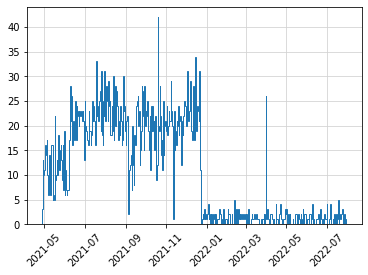

In [21]:
t_tot = pd.to_numeric(df_housing.time[~df_housing.time.isnull()]) * 1e-9 # convert to seconds

t_tot_u = np.unique(t_tot)
steps = 24*3600  # how many seconds are in one bin
t_start = t_tot_u[0] - t_tot_u[0] % steps # start the bins at midnight
t_end = t_tot_u[-1] - t_tot_u[-1] % steps + steps
bins = np.arange(t_start , t_end, steps)  # number of bins = number of days


# histogram of all pictures

counts_tot, bin_edges_tot = np.histogram(t_tot_u, bins=bins)
counts_tot = np.ma.masked_equal(counts_tot, 0)

date_edges = strawb.tools.asdatetime(bin_edges_tot)

fig, ax = plt.subplots()

#plt.figure(figsize=(w, 3.5))
plt.xticks(rotation=45)
plt.stairs(counts_tot, date_edges)
#plt.xlabel('Date')
plt.grid(color='lightgray')
plt.gca().set_axisbelow(True)

## LED Activitiy

In [20]:
led = pd.read_pickle('lucifer_settings_20210225T152529_20220907T212744.gz')
led = led[~led.t_previous_image.isnull()]
led.t_previous_image = pd.to_datetime(led.t_previous_image, utc=True)

In [21]:
t_led = [i for i in led.t_previous_image]

In [22]:
df_no_led = df_fov.copy()
df_no_led = df_no_led[~df_no_led['time'].isin(t_led)]
df_no_led

,mean_std_n,mean_std_start,mean_std_stop,label,time,field_of_view,center_of_mass_x,center_of_mass_y,center_of_pix_x,center_of_pix_y,...,n_pixel_blue,noise_blue,charge_with_noise_blue,sn_mean_deviation_blue,sn_mean_deviation_sigma_blue,angle,box_center_x,box_center_y,box_size_x,box_size_y
73,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,3180.0,2021-04-28 22:49:25.208035328+00:00,True,506.628745,546.630474,506.683544,547.303797,...,21.0,117188.545455,532112.0,19758.259740,4.023935,78.690071,506.000000,546.000061,32.555279,12.159200
74,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,3256.0,2021-04-28 22:49:25.208035328+00:00,True,517.618791,541.177465,517.400000,540.400000,...,6.0,28230.545455,137152.0,18153.575758,3.866049,75.256439,516.606262,538.103699,30.539196,4.886271
75,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,3289.0,2021-04-28 22:49:25.208035328+00:00,True,524.055583,538.266472,523.806452,537.612903,...,6.0,41284.545455,153792.0,18751.242424,3.807413,78.690071,523.769287,539.846252,42.361084,3.922322
76,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,3774.0,2021-04-28 22:49:25.208035328+00:00,True,604.271737,492.135053,604.240000,492.880000,...,2.0,10410.727273,44384.0,16986.636364,3.631974,86.987213,604.493042,492.868774,29.853416,8.567090
121,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,3112.0,2021-04-28 23:41:33.670472704+00:00,True,549.858733,210.402563,549.142857,208.476190,...,5.0,10859.272727,118688.0,21565.745455,4.782613,61.927513,548.129761,204.930817,20.705883,5.117647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485969,288,2022-07-30 00:00:00+00:00,2022-07-30 07:59:59.999999+00:00,878.0,2022-07-30 06:41:04.152556288+00:00,True,445.256376,639.834651,444.764706,640.549020,...,15.0,60271.777778,109920.0,3309.881481,5.554050,59.036240,444.073517,640.955933,6.859943,14.234381
486362,290,2022-07-30 16:00:00+00:00,2022-07-30 23:59:59.999999+00:00,1128.0,2022-07-30 17:32:25.001512704+00:00,True,560.057175,558.728410,560.285714,558.785714,...,10.0,39429.075862,62992.0,2356.292414,4.383335,32.005383,560.089905,557.056213,25.227951,4.875990
486634,287,2022-07-31 00:00:00+00:00,2022-07-31 07:59:59.999999+00:00,1010.0,2022-07-31 01:02:40.676560128+00:00,True,425.964518,95.859980,431.861284,82.894410,...,136.0,472986.871080,1581472.0,8150.625948,8.220321,27.050596,438.233765,72.917229,16.523571,99.766739
486666,287,2022-07-31 00:00:00+00:00,2022-07-31 07:59:59.999999+00:00,2178.0,2022-07-31 01:51:02.345961984+00:00,True,918.883400,35.138538,918.538462,33.820513,...,13.0,60384.836237,103792.0,3339.012597,5.199097,73.610458,917.090637,31.708614,20.033808,7.787791


## ----------------------------------------------------------------------------------------------------------

# Center of Mass/Pixels/Minimum Bounding Box

## Blobb issue

In [17]:
df_22 = df_i[df_i.time > '2022-01-01']
df_21 = df_i[df_i.time < '2022-01-01']

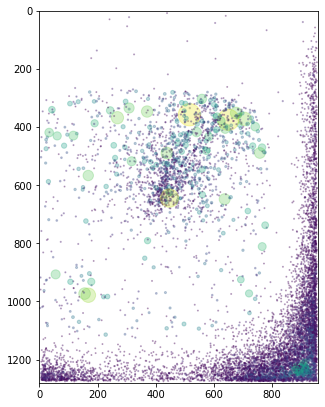

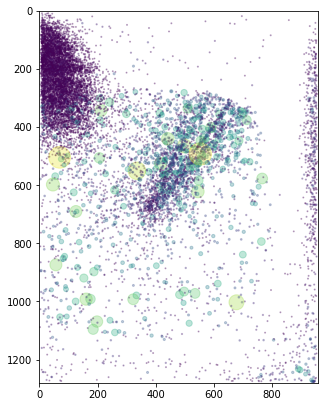

In [23]:
norm_size = scipy.interpolate.interp1d([df_22.n_pixel.min(), df_22.n_pixel.max()], [s_min, s_max])

fig, ax = plt.subplots(figsize=(5, 7))
plt.scatter(df_22.center_of_mass_y, df_22.center_of_mass_x, c=df_22.n_pixel, s=norm_size(df_22.n_pixel), 
            cmap=cmap, norm=matplotlib.colors.LogNorm(),
            alpha=.3)
plt.xlim(0, 960)
plt.ylim(1280, 0)
ax.set_aspect('equal', 'box')
plt.show()


norm_size = scipy.interpolate.interp1d([df_21.n_pixel.min(), df_21.n_pixel.max()], [s_min, s_max])

fig, ax = plt.subplots(figsize=(5, 7))
plt.scatter(df_21.center_of_mass_y, df_21.center_of_mass_x, c=df_21.n_pixel, s=norm_size(df_21.n_pixel), 
            cmap=cmap, norm=matplotlib.colors.LogNorm(),
            alpha=.3)
plt.xlim(0, 960)
plt.ylim(1280, 0)
ax.set_aspect('equal', 'box')
plt.show()

In [23]:
mask_blobb = df_i['center_of_mass_x'] < 400
mask_blobb &= df_i['center_of_mass_y'] < 200

df_blobb = df_i[mask_blobb]
df_blobb

,mean_std_n,mean_std_start,mean_std_stop,label,time,center_of_mass_x,center_of_mass_y,center_of_pix_x,center_of_pix_y,n_pixel,...,n_pixel_blue,noise_blue,charge_with_noise_blue,sn_mean_deviation_blue,sn_mean_deviation_sigma_blue,angle,box_center_x,box_center_y,box_size_x,box_size_y
32,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,262.0,2021-04-28 22:12:30.742815232+00:00,65.007087,38.244226,65.333333,37.285714,21.0,...,2.0,1909.636364,21152.0,9621.181818,4.707496,8.530765,65.795845,37.194374,11.620002,27.640770
53,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,1197.0,2021-04-28 22:30:57.184480256+00:00,206.581208,40.891494,207.000000,40.956522,23.0,...,5.0,5472.000000,48560.0,8617.600000,4.073540,75.068581,208.016617,39.062244,20.741844,16.748074
91,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,1213.0,2021-04-28 23:09:37.571655680+00:00,221.104722,114.982776,221.227273,114.863636,22.0,...,5.0,5803.090909,44320.0,7703.381818,3.629810,29.248827,219.844711,113.813026,32.143124,11.551979
217,273,2021-04-29 00:00:00+00:00,2021-04-29 07:59:59.999999+00:00,1477.0,2021-04-29 01:50:13.711025920+00:00,213.029556,72.497382,213.363636,72.136364,22.0,...,4.0,3725.948718,38336.0,8652.512821,4.453881,23.629379,213.650833,69.940979,11.337445,22.503111
220,273,2021-04-29 00:00:00+00:00,2021-04-29 07:59:59.999999+00:00,2068.0,2021-04-29 01:51:55.787184128+00:00,268.068822,44.262563,267.800000,44.560000,25.0,...,5.0,8218.315018,55520.0,9460.336996,3.875378,21.250502,267.014740,43.033516,14.653186,22.937672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461693,289,2022-07-04 08:00:00+00:00,2022-07-04 15:59:59.999999+00:00,822.0,2022-07-04 11:11:08.393806848+00:00,361.809919,199.691878,366.917391,202.652174,230.0,...,72.0,252126.726644,586928.0,4650.017686,6.700416,23.805943,373.053986,205.244400,50.024479,17.571806
463477,290,2022-07-06 00:00:00+00:00,2022-07-06 07:59:59.999999+00:00,297.0,2022-07-06 07:01:27.564604416+00:00,136.700319,197.405115,137.000000,197.809524,42.0,...,9.0,32033.048276,196352.0,18257.661303,12.078146,40.914387,136.236038,197.304565,27.658218,1.964792
467182,289,2022-07-10 08:00:00+00:00,2022-07-10 15:59:59.999999+00:00,542.0,2022-07-10 10:32:20.194139904+00:00,279.471917,172.866578,279.761905,174.205128,273.0,...,68.0,229607.086505,401920.0,2534.013434,5.155078,45.000000,278.250031,176.250000,40.305084,24.041630
468735,289,2022-07-12 00:00:00+00:00,2022-07-12 07:59:59.999999+00:00,689.0,2022-07-12 03:41:05.096336896+00:00,319.710111,121.894440,319.768595,122.950413,121.0,...,32.0,107090.712803,168080.0,1905.915225,4.070759,90.000000,320.000000,124.500000,53.000000,6.000000


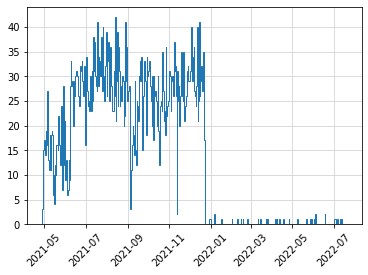

In [30]:
t_tot = pd.to_numeric(df_blobb.time[~df_blobb.time.isnull()]) * 1e-9 # convert to seconds

t_tot_u = np.unique(t_tot)
steps = 24*3600  # how many seconds are in one bin
t_start = t_tot_u[0] - t_tot_u[0] % steps # start the bins at midnight
t_end = t_tot_u[-1] - t_tot_u[-1] % steps + steps
bins = np.arange(t_start , t_end, steps)  # number of bins = number of days


# histogram of all pictures

counts_tot, bin_edges_tot = np.histogram(t_tot_u, bins=bins)
counts_tot = np.ma.masked_equal(counts_tot, 0)

date_edges = strawb.tools.asdatetime(bin_edges_tot)

fig, ax = plt.subplots()

#plt.figure(figsize=(w, 3.5))
plt.xticks(rotation=45)
plt.stairs(counts_tot, date_edges)
#plt.xlabel('Date')
plt.grid(color='lightgray')
plt.gca().set_axisbelow(True)

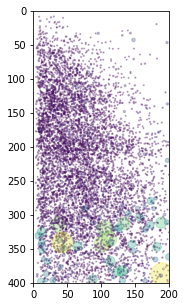

In [43]:
norm_size = scipy.interpolate.interp1d([df_blobb.n_pixel.min(), df_blobb.n_pixel.max()], [s_min, s_max])

fig, ax = plt.subplots(figsize=(3, 5))
plt.scatter(df_blobb.center_of_mass_y, df_blobb.center_of_mass_x, c=df_blobb.n_pixel, s=norm_size(df_blobb.n_pixel), 
            cmap=cmap, norm=matplotlib.colors.LogNorm(),
            alpha=.3)
plt.xlim(0, 200)
plt.ylim(400, 0)
ax.set_aspect('equal', 'box')

In [216]:
df_blobb.groupby(['n_pixel'])['n_pixel'].count()

n_pixel
21.0      1902
22.0      1455
23.0       965
24.0       722
25.0       488
          ... 
1034.0       1
1184.0       1
1205.0       1
2040.0       1
2441.0       1
Name: n_pixel, Length: 98, dtype: int64

In [325]:
# count how often a time/picture appears ( = how many clusters in that picture)
time_counts = df_blobb.groupby(['time'])['time'].count()  
time_counts

time
2021-04-28 22:12:30.742815232+00:00    1
2021-04-28 22:30:57.184480256+00:00    1
2021-04-28 23:09:37.571655680+00:00    1
2021-04-29 01:50:13.711025920+00:00    1
2021-04-29 01:51:55.787184128+00:00    1
                                      ..
2022-07-04 11:11:08.393806848+00:00    2
2022-07-06 07:01:27.564604416+00:00    1
2022-07-10 10:32:20.194139904+00:00    1
2022-07-12 03:41:05.096336896+00:00    1
2022-07-20 20:39:03.979597824+00:00    1
Name: time, Length: 6075, dtype: int64

In [326]:
np.unique(list(time_counts))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 17])

In [327]:
time_counts[time_counts >= 5]

time
2021-04-30 03:02:55.156378880+00:00     7
2021-05-17 14:50:58.055185920+00:00    17
2021-06-22 16:04:47.990044928+00:00     6
2021-07-07 15:15:18.200172544+00:00     5
2021-07-11 09:04:52.771292416+00:00     5
2021-08-09 21:10:22.646203648+00:00     6
2021-08-10 15:48:50.483918336+00:00     5
2021-08-12 23:01:27.416272896+00:00     8
2021-08-24 15:45:05.444398336+00:00     5
2021-09-04 01:59:21.367806720+00:00     5
2021-09-20 05:06:40.333888512+00:00     5
2021-09-21 22:56:43.474919168+00:00     6
2021-10-02 16:28:13.578040320+00:00     5
2021-10-07 20:02:43.320914688+00:00     5
2021-10-25 17:18:44.678956800+00:00     9
2021-11-03 15:39:00.714684928+00:00     6
2021-11-08 02:44:12.322072064+00:00     5
2021-11-16 21:55:52.252323072+00:00     5
2021-12-01 22:10:42.611706624+00:00     6
2021-12-05 02:55:46.996641536+00:00     6
Name: time, dtype: int64

In [218]:
df_single = df_i[df_i.time == '2021-10-25 17:18:44.678956800+00:00']

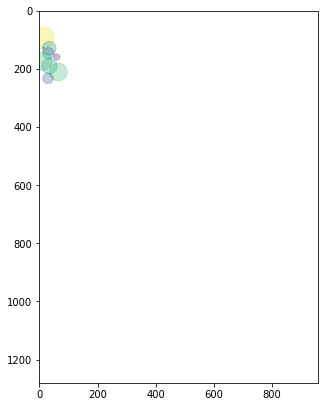

In [219]:
norm_size = scipy.interpolate.interp1d([df_single.n_pixel.min(), df_single.n_pixel.max()], [s_min, s_max])

fig, ax = plt.subplots(figsize=(5, 7))
plt.scatter(df_single.center_of_mass_y, df_single.center_of_mass_x, c=df_single.n_pixel, s=norm_size(df_single.n_pixel), 
            cmap=cmap, norm=matplotlib.colors.LogNorm(),
            alpha=.3)
plt.xlim(0, 960)
plt.ylim(1280, 0)
#plt.xlim(0, 200)
#plt.ylim(400, 0)
ax.set_aspect('equal', 'box')

In [270]:
list(np.unique(df_blobb.time))

[Timestamp('2021-04-28 22:12:30.742815232+0000', tz='UTC'),
 Timestamp('2021-04-28 22:30:57.184480256+0000', tz='UTC'),
 Timestamp('2021-04-28 23:09:37.571655680+0000', tz='UTC'),
 Timestamp('2021-04-29 01:50:13.711025920+0000', tz='UTC'),
 Timestamp('2021-04-29 01:51:55.787184128+0000', tz='UTC'),
 Timestamp('2021-04-29 05:18:12.972520448+0000', tz='UTC'),
 Timestamp('2021-04-29 06:52:43.578873600+0000', tz='UTC'),
 Timestamp('2021-04-29 07:12:52.236131584+0000', tz='UTC'),
 Timestamp('2021-04-29 08:35:17.318002688+0000', tz='UTC'),
 Timestamp('2021-04-29 13:37:57.980022784+0000', tz='UTC'),
 Timestamp('2021-04-29 14:14:56.500393472+0000', tz='UTC'),
 Timestamp('2021-04-29 14:41:54.564967424+0000', tz='UTC'),
 Timestamp('2021-04-29 15:42:25.505299968+0000', tz='UTC'),
 Timestamp('2021-04-29 16:16:00.421869056+0000', tz='UTC'),
 Timestamp('2021-04-29 20:04:41.764825088+0000', tz='UTC'),
 Timestamp('2021-04-29 20:36:37.598446080+0000', tz='UTC'),
 Timestamp('2021-04-29 23:41:36.16829260

In [45]:
df_times_blobb = df_i[df_i['time'].isin(list(np.unique(df_blobb.time)))]

In [306]:
df_times_blobb

,mean_std_n,mean_std_start,mean_std_stop,label,time,center_of_mass_x,center_of_mass_y,center_of_pix_x,center_of_pix_y,n_pixel,...,n_pixel_blue,noise_blue,charge_with_noise_blue,sn_mean_deviation_blue,sn_mean_deviation_sigma_blue,angle,box_center_x,box_center_y,box_size_x,box_size_y
32,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,262.0,2021-04-28 22:12:30.742815232+00:00,65.007087,38.244226,65.333333,37.285714,21.0,...,2.0,1909.636364,21152.0,9621.181818,4.707496,8.530765,65.795845,37.194374,11.620002,27.640770
53,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,1197.0,2021-04-28 22:30:57.184480256+00:00,206.581208,40.891494,207.000000,40.956522,23.0,...,5.0,5472.000000,48560.0,8617.600000,4.073540,75.068581,208.016617,39.062244,20.741844,16.748074
91,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,1213.0,2021-04-28 23:09:37.571655680+00:00,221.104722,114.982776,221.227273,114.863636,22.0,...,5.0,5803.090909,44320.0,7703.381818,3.629810,29.248827,219.844711,113.813026,32.143124,11.551979
217,273,2021-04-29 00:00:00+00:00,2021-04-29 07:59:59.999999+00:00,1477.0,2021-04-29 01:50:13.711025920+00:00,213.029556,72.497382,213.363636,72.136364,22.0,...,4.0,3725.948718,38336.0,8652.512821,4.453881,23.629379,213.650833,69.940979,11.337445,22.503111
220,273,2021-04-29 00:00:00+00:00,2021-04-29 07:59:59.999999+00:00,2068.0,2021-04-29 01:51:55.787184128+00:00,268.068822,44.262563,267.800000,44.560000,25.0,...,5.0,8218.315018,55520.0,9460.336996,3.875378,21.250502,267.014740,43.033516,14.653186,22.937672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461693,289,2022-07-04 08:00:00+00:00,2022-07-04 15:59:59.999999+00:00,822.0,2022-07-04 11:11:08.393806848+00:00,361.809919,199.691878,366.917391,202.652174,230.0,...,72.0,252126.726644,586928.0,4650.017686,6.700416,23.805943,373.053986,205.244400,50.024479,17.571806
463477,290,2022-07-06 00:00:00+00:00,2022-07-06 07:59:59.999999+00:00,297.0,2022-07-06 07:01:27.564604416+00:00,136.700319,197.405115,137.000000,197.809524,42.0,...,9.0,32033.048276,196352.0,18257.661303,12.078146,40.914387,136.236038,197.304565,27.658218,1.964792
467182,289,2022-07-10 08:00:00+00:00,2022-07-10 15:59:59.999999+00:00,542.0,2022-07-10 10:32:20.194139904+00:00,279.471917,172.866578,279.761905,174.205128,273.0,...,68.0,229607.086505,401920.0,2534.013434,5.155078,45.000000,278.250031,176.250000,40.305084,24.041630
468735,289,2022-07-12 00:00:00+00:00,2022-07-12 07:59:59.999999+00:00,689.0,2022-07-12 03:41:05.096336896+00:00,319.710111,121.894440,319.768595,122.950413,121.0,...,32.0,107090.712803,168080.0,1905.915225,4.070759,90.000000,320.000000,124.500000,53.000000,6.000000


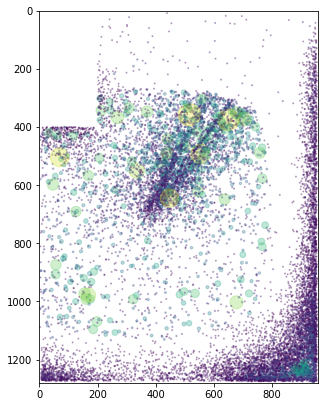

In [176]:
norm_size = scipy.interpolate.interp1d([df_i_rest.n_pixel.min(), df_i_rest.n_pixel.max()], [s_min, s_max])

fig, ax = plt.subplots(figsize=(5, 7))
plt.scatter(df_i_rest.center_of_mass_y, df_i_rest.center_of_mass_x, c=df_i_rest.n_pixel, s=norm_size(df_i_rest.n_pixel), 
            cmap=cmap, norm=matplotlib.colors.LogNorm(),
            alpha=.3)
plt.xlim(0, 960)
plt.ylim(1280, 0)
#plt.xlim(0, 200)
#plt.ylim(400, 0)
ax.set_aspect('equal', 'box') 

In [78]:
df_times_blobb_21 = df_times_blobb[df_times_blobb.time < '2022']
df_times_blobb_22 = df_times_blobb[df_times_blobb.time >= '2022']

In [111]:
df_times_blobb.groupby(['n_pixel'])['n_pixel'].count()

n_pixel
21.0      1980
22.0      1516
23.0      1010
24.0       748
25.0       517
          ... 
2132.0       1
2441.0       1
2478.0       1
4896.0       1
5523.0       1
Name: n_pixel, Length: 179, dtype: int64

In [182]:
mask_b = (df_i.center_of_mass_x <= 400) & (df_i.center_of_mass_y <= 200)

df_i_blobb = df_i[mask_b]
df_i_rest = df_i[~mask_b]

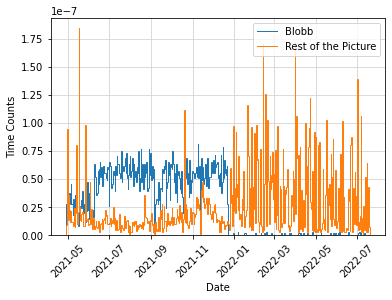

In [203]:
t_tot = pd.to_numeric(df_i_blobb.time[~df_i_blobb.time.isnull()]) * 1e-9 # convert to seconds

t_tot_u = np.unique(t_tot)
steps = 24*3600  # how many seconds are in one bin
t_start = t_tot_u[0] - t_tot_u[0] % steps # start the bins at midnight
t_end = t_tot_u[-1] - t_tot_u[-1] % steps + steps
bins = np.arange(t_start , t_end, steps)  # number of bins = number of days


# histogram blobb

counts_tot_blobb, bin_edges_blobb = np.histogram(t_tot, density=True, bins=bins)
counts_tot_blobb = np.ma.masked_equal(counts_tot_blobb, 0)

date_edges = strawb.tools.asdatetime(bin_edges_blobb)

fig, ax = plt.subplots()

plt.xticks(rotation=45)
plt.stairs(counts_tot_blobb, date_edges, label='Blobb')
plt.grid(color='lightgray')
plt.gca().set_axisbelow(True)


# histogram rest

t = pd.to_numeric(df_i_rest.time[mask_para][~df_i_rest.time.isnull()]) * 1e-9 # convert to seconds
t_u = np.unique(t)

counts, bin_edges = np.histogram(t, density=True, bins=bins)
counts = np.ma.masked_equal(counts, 0)

plt.xticks(rotation=45)
plt.stairs(counts, date_edges, label='Rest of the Picture')
plt.grid(color='lightgray')
plt.gca().set_axisbelow(True)
plt.ylabel('Time Counts')
plt.xlabel('Date')
plt.legend()
plt.show()



Text(0, 0.5, 'counts')

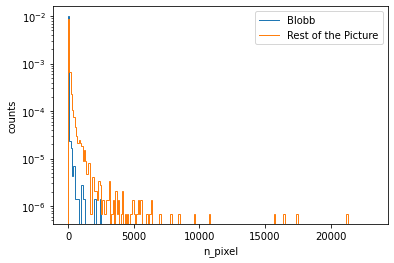

In [253]:
n_u = np.unique(df_i.n_pixel)
n_steps = 100  # how many seconds are in one bin
n_start = n_u[0] - n_u[0] % n_steps # start the bins at midnight
n_end = n_u[-1] - n_u[-1] % n_steps + n_steps
n_bins = np.arange(n_start , n_end, n_steps)

c, e = np.histogram(df_i_blobb.n_pixel, density=True, bins=n_bins)
c_rest, e_rest = np.histogram(df_i_rest.n_pixel, density=True, bins=n_bins)
c_tot, e_tot = np.histogram(df_i.n_pixel, density=True, bins=n_bins)


plt.stairs(c, e, label='Blobb')
plt.stairs(c_rest, e_rest, label='Rest of the Picture')
#plt.stairs(c_tot, e_tot)
plt.yscale('log')
plt.legend()
plt.xlabel('n_pixel')
plt.ylabel('counts')

Text(0, 0.5, 'counts')

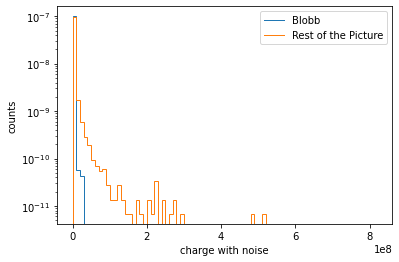

In [247]:
charge_u = np.unique(df_i.charge_with_noise)
charge_steps = 10000000  # how many seconds are in one bin
charge_start = charge_u[0] - charge_u[0] % charge_steps # start the bins at midnight
charge_end = charge_u[-1] - charge_u[-1] % charge_steps + charge_steps
charge_bins = np.arange(charge_start , charge_end, charge_steps)

ch, ed = np.histogram(df_i_blobb.charge_with_noise, density=True, bins=charge_bins)
ch_rest, ed_rest = np.histogram(df_i_rest.charge_with_noise, density=True, bins=charge_bins)
ch_tot, ed_tot = np.histogram(df_i.charge_with_noise, density=True, bins=charge_bins)


plt.stairs(ch, ed, label='Blobb')
plt.stairs(ch_rest, ed_rest, label='Rest of the Picture')
#plt.stairs(ch_tot, ed_tot)
plt.yscale('log')
plt.legend()
plt.xlabel('charge with noise')
plt.ylabel('counts')

In [225]:
charge_u[-1]

826050544.0

In [282]:
import math


In [287]:
df_i['n_pixel'].max()

23202.0

In [298]:
def hist(column):
    column_u = np.unique(df_i[str(column)])
    p = math.floor(math.log10(df_i[str(column)].max()))
    steps =  10**(p-2)
    start = column_u[0] - column_u[0] % steps 
    end = column_u[-1] - column_u[-1] % steps + steps
    bins = np.arange(start , end, steps)

    c, e = np.histogram(df_i_blobb[str(column)], density=True, bins=bins)
    c_rest, e_rest = np.histogram(df_i_rest[str(column)], density=True, bins=bins)


    plt.stairs(c, e, label='Blobb')
    plt.stairs(c_rest, e_rest, label='Rest of the Picture')
    plt.yscale('log')
    plt.legend()
    plt.xlabel(str(column))
    plt.ylabel('counts')
    plt.show()

In [295]:
df_i

,mean_std_n,mean_std_start,mean_std_stop,label,time,center_of_mass_x,center_of_mass_y,center_of_pix_x,center_of_pix_y,n_pixel,...,n_pixel_blue,noise_blue,charge_with_noise_blue,sn_mean_deviation_blue,sn_mean_deviation_sigma_blue,angle,box_center_x,box_center_y,box_size_x,box_size_y
32,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,262.0,2021-04-28 22:12:30.742815232+00:00,65.007087,38.244226,65.333333,37.285714,21.0,...,2.0,1909.636364,21152.0,9621.181818,4.707496,8.530765,65.795845,37.194374,11.620002,27.640770
53,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,1197.0,2021-04-28 22:30:57.184480256+00:00,206.581208,40.891494,207.000000,40.956522,23.0,...,5.0,5472.000000,48560.0,8617.600000,4.073540,75.068581,208.016617,39.062244,20.741844,16.748074
73,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,3180.0,2021-04-28 22:49:25.208035328+00:00,506.628745,546.630474,506.683544,547.303797,79.0,...,21.0,117188.545455,532112.0,19758.259740,4.023935,78.690071,506.000000,546.000061,32.555279,12.159200
74,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,3256.0,2021-04-28 22:49:25.208035328+00:00,517.618791,541.177465,517.400000,540.400000,30.0,...,6.0,28230.545455,137152.0,18153.575758,3.866049,75.256439,516.606262,538.103699,30.539196,4.886271
75,88,2021-04-28 16:00:00+00:00,2021-04-28 23:59:59.999999+00:00,3289.0,2021-04-28 22:49:25.208035328+00:00,524.055583,538.266472,523.806452,537.612903,31.0,...,6.0,41284.545455,153792.0,18751.242424,3.807413,78.690071,523.769287,539.846252,42.361084,3.922322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486846,287,2022-07-31 00:00:00+00:00,2022-07-31 07:59:59.999999+00:00,11643.0,2022-07-31 04:25:37.366686976+00:00,1265.430731,620.532211,1265.666667,620.575758,33.0,...,9.0,76984.250871,105872.0,3209.749903,3.473718,32.905247,1265.365967,618.707336,29.533115,17.384041
486848,287,2022-07-31 00:00:00+00:00,2022-07-31 07:59:59.999999+00:00,11657.0,2022-07-31 04:25:37.366686976+00:00,1267.005626,827.706951,1267.043478,827.507246,69.0,...,17.0,195751.080139,260320.0,3798.171757,3.469084,8.530765,1267.599121,828.839905,20.223749,29.470304
486849,287,2022-07-31 00:00:00+00:00,2022-07-31 07:59:59.999999+00:00,11658.0,2022-07-31 04:25:37.366686976+00:00,1271.049631,31.445999,1271.181818,31.060606,33.0,...,13.0,155740.822300,203392.0,3665.475208,3.514338,37.303947,1271.615479,32.254662,16.287411,28.446156
486850,287,2022-07-31 00:00:00+00:00,2022-07-31 07:59:59.999999+00:00,11665.0,2022-07-31 04:25:37.366686976+00:00,1268.663515,706.616976,1268.645161,706.645161,62.0,...,15.0,146051.790941,198992.0,3529.347271,3.513486,83.088768,1267.207275,708.459656,47.591053,17.989540


In [296]:
columns = set(df_i.columns)
columns = columns.difference(['mean_std_n', 'mean_std_start', 'mean_std_stop',
                              'time', 'label', 'box_center_x', 'box_center_y', 'sn_mean_deviation',
                              'sn_mean_deviation_blue', 'sn_mean_deviation_green', 'sn_mean_deviation_red',
                              'sn_mean_deviation_sigma', 'sn_mean_deviation_sigma_blue', 
                              'sn_mean_deviation_sigma_green', 'sn_mean_deviation_sigma_red'])
columns

{'angle',
 'box_size_x',
 'box_size_y',
 'center_of_mass_x',
 'center_of_mass_y',
 'center_of_pix_x',
 'center_of_pix_y',
 'charge_with_noise',
 'charge_with_noise_blue',
 'charge_with_noise_green',
 'charge_with_noise_red',
 'n_pixel',
 'n_pixel_blue',
 'n_pixel_green',
 'n_pixel_red',
 'noise',
 'noise_blue',
 'noise_green',
 'noise_red'}

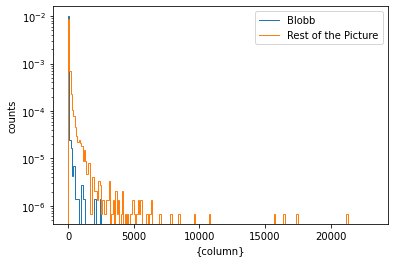

In [293]:
hist('n_pixel')

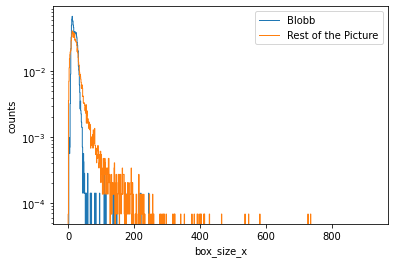

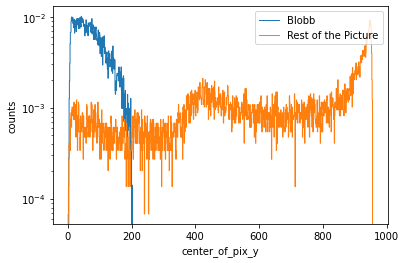

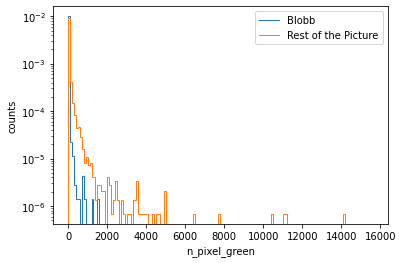

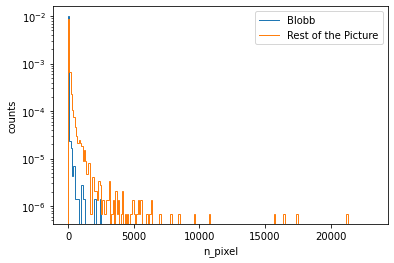

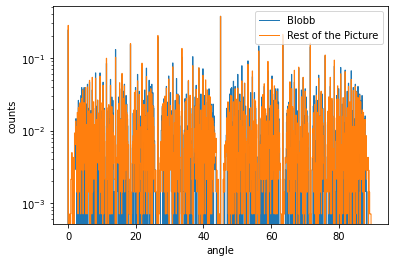

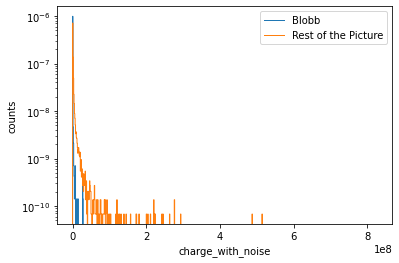

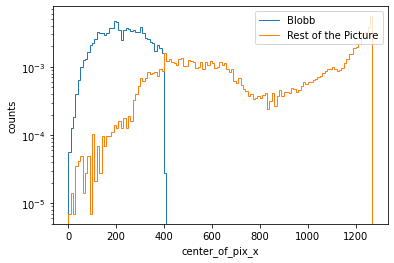

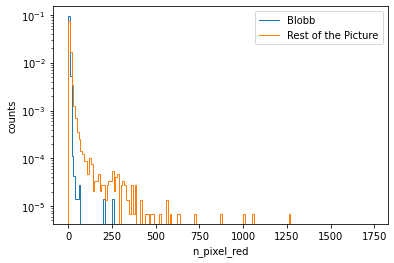

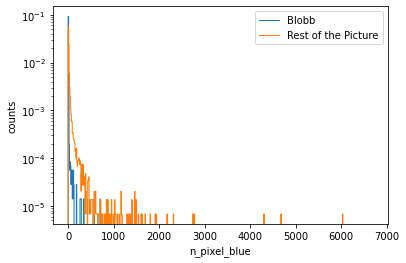

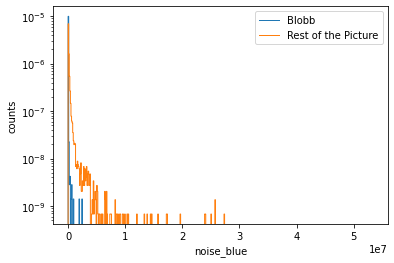

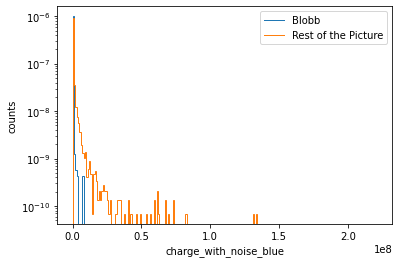

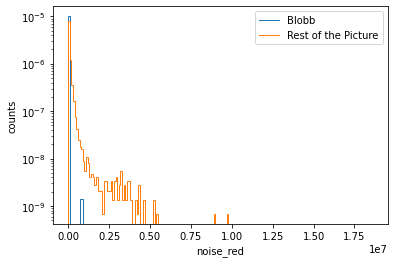

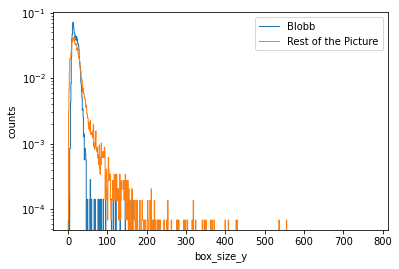

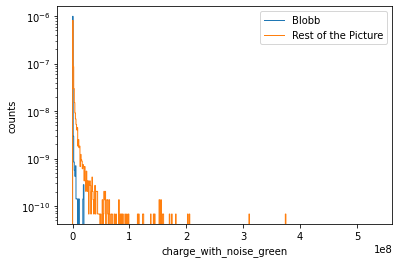

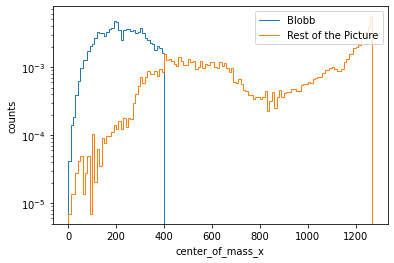

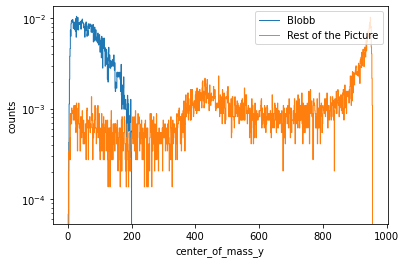

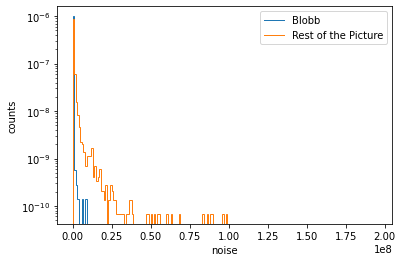

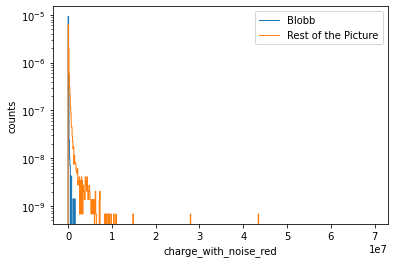

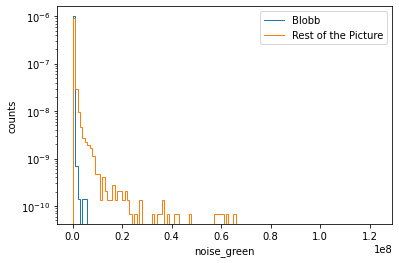

In [299]:
for col_i in columns:
    hist(col_i)

In [316]:
df_i.columns

Index(['mean_std_n', 'mean_std_start', 'mean_std_stop', 'label', 'time',
       'center_of_mass_x', 'center_of_mass_y', 'center_of_pix_x',
       'center_of_pix_y', 'n_pixel', 'noise', 'charge_with_noise',
       'sn_mean_deviation', 'sn_mean_deviation_sigma', 'n_pixel_red',
       'noise_red', 'charge_with_noise_red', 'sn_mean_deviation_red',
       'sn_mean_deviation_sigma_red', 'n_pixel_green', 'noise_green',
       'charge_with_noise_green', 'sn_mean_deviation_green',
       'sn_mean_deviation_sigma_green', 'n_pixel_blue', 'noise_blue',
       'charge_with_noise_blue', 'sn_mean_deviation_blue',
       'sn_mean_deviation_sigma_blue', 'angle', 'box_center_x', 'box_center_y',
       'box_size_x', 'box_size_y'],
      dtype='object')

In [328]:
[df_i.columns[i] for i in [5, 6, 10]]

['center_of_mass_x', 'center_of_mass_y', 'noise']

In [327]:
df_i.columns[5:12]

Index(['center_of_mass_x', 'center_of_mass_y', 'center_of_pix_x',
       'center_of_pix_y', 'n_pixel', 'noise', 'charge_with_noise'],
      dtype='object')

In [308]:
# Set up a plotting function for fast df insights
def stair_scatter(df, color=None, size=1, alpha=.1, ax=None, columns=None, log=True, **kwargs):
    if columns is None:
        columns = df.columns
    rows = columns[1:] 
    cols = columns[:-1]
    
    # ax[row, col]
    if ax is None:
        fig, ax = plt.subplots(nrows=len(rows), 
                       ncols=len(cols), 
                       sharex='col', sharey='row', 
                       squeeze=False, 
                       **kwargs)
        
        for j, cols_j in enumerate(cols):
            if log:
                ax[-1,j].set_xscale('log')
            ax[-1,j].set_xlabel(cols_j.replace('_',' '), rotation=0) #rotation=70
        for i, row_i in enumerate(rows):
            ax[i, 0].set_ylabel(row_i.replace('_',' '), rotation=90) #rotation=30)
            if log:
                ax[i, 0].set_yscale('log')
        for i, row_i in enumerate(rows):
            for j, cols_j in enumerate(cols):
                if j<=i:
                    ax[i, j].grid()
                else:
                    ax[i,j].axis('off')

    for i, row_i in enumerate(rows):
        for j, cols_j in enumerate(cols):
            if j<=i:#cols_j != row_i:
    #             ax[i, j].text(0.5, 0.5, f'x:{cols_j}\ny:{row_i}', 
    #                           horizontalalignment='center',
    #                           verticalalignment='center', 
    #                           transform=ax[i, j].transAxes)
                ax[i, j].scatter(df[cols_j], df[row_i], s=size, c=color, alpha=alpha)
        
    return ax

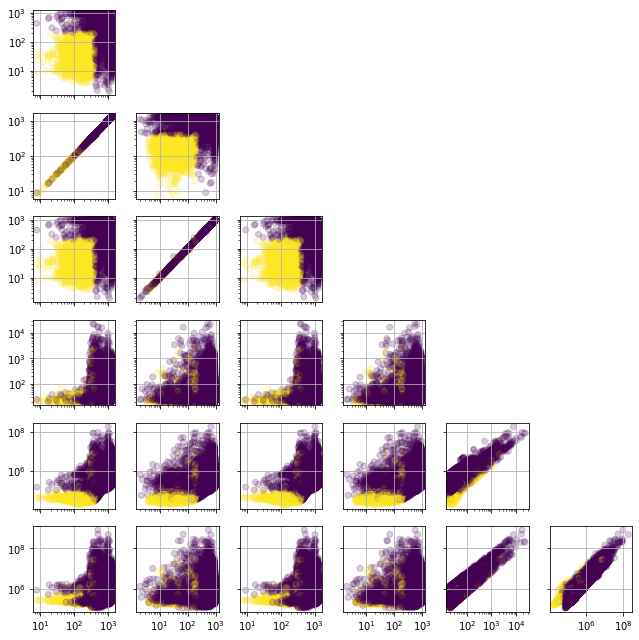

In [338]:
stair_scatter(df_i, 
              color=mask_b,
              size=None,
              columns=df_i.columns[5:12],
              alpha=.2,
              figsize=(9,9))

plt.tight_layout()

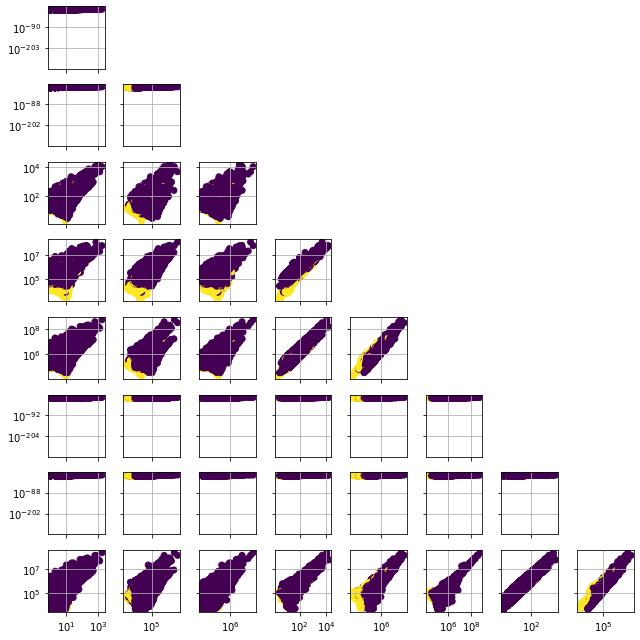

In [336]:
stair_scatter(df_i, 
              color=mask_b,
              size=None,
              columns=[df_i.columns[i] for i in [14, 15, 16, 19, 20, 21, 24, 25, 26]],
              alpha=1,
              figsize=(9,9))

plt.tight_layout()

# n_pixel, noise, charge

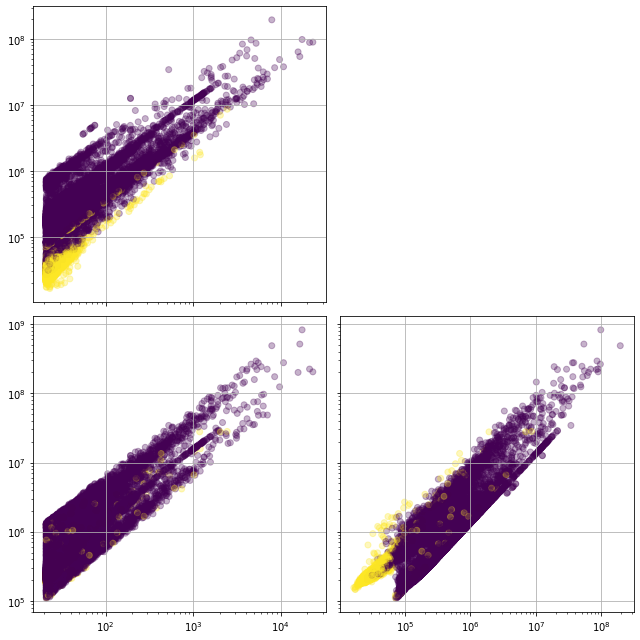

In [344]:
stair_scatter(df_i, 
              color=mask_b,
              size=None,
              columns=[df_i.columns[i] for i in [9, 10, 11]],
              alpha=.3,
              figsize=(9,9))

plt.tight_layout()

/home/straw/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:1134: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


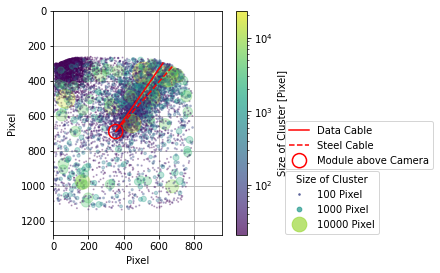

In [199]:
center_of_mass_y = df_fov['center_of_mass_x'].to_numpy()
center_of_mass_x = df_fov['center_of_mass_y'].to_numpy()

### Scatter plot ###
# def. linear norm function for marker size, maps [c.min(), c.max()] -> [s_min, s_max]
# min and max size of markers
s_min=1.
s_max=5e2
norm_size = scipy.interpolate.interp1d([df_fov.n_pixel.min(), df_fov.n_pixel.max()], [s_min, s_max])

# def. cmap, select one
#cmap=strawb.tools.cmap_manipulator('viridis_r', v_min=.03, v_max=1)  # v_min=.03 - cuts the yellow part
cmap=strawb.tools.cmap_manipulator('viridis', v_min=0, v_max=.97)  # v_max=.97 - cuts the yellow part
#cmap=strawb.tools.cmap_manipulator('Blues', v_min=.35, v_max=1)  #  v_min=.3 - cuts the white part


### PLOT
fig, ax = plt.subplots(figsize=(w, 3.9))
sc = plt.scatter(center_of_mass_x, center_of_mass_y, c=df_fov.n_pixel, s=norm_size(df_fov.n_pixel), 
                 cmap=cmap, norm=matplotlib.colors.LogNorm(),
                 alpha=.3)


plt.scatter(module_x, module_y, s=200, facecolors='none', edgecolors='red', 
            label='Module above Camera', linewidth=1.5) 
ax.plot([625, module_x], [300, module_y], 'r-', linewidth=1.5, label='Data Cable')
ax.plot([678, module_x], [320, module_y], 'r', linewidth=1.5, linestyle='--', label = 'Steel Cable')
ax.legend(loc='lower right', prop={'size':12})

legend1 = ax.legend(loc='lower left', bbox_to_anchor = (1.35, .27))
ax.add_artist(legend1)


# colorbar
cb = plt.colorbar(sc)
cb.set_label("Size of Cluster [Pixel]")
# make alpha different for the colorbar
cb.set_alpha(.7)
cb.draw_all()


### LEGEND START
# get the legend - maybe there is a better solution
num = matplotlib.ticker.LogLocator(numticks=6).tick_values(df_fov.n_pixel.min(), df_fov.n_pixel.max())

fmt = "{x:.0f} Pixel"
legends_c = sc.legend_elements(prop="colors", num=num, fmt=fmt, alpha=.7)


# generate the legend entries with color and size
# generation of legends_c_pos must match! sc.legend_elements(..., fmt,...)
fmt_e = fmt.split('{x')[1].split('}', 1)[1]
fmt_s = fmt.split('{x')[0]

legends_c_pos = np.array([i.replace(fmt_e, '').replace(fmt_s, '') for i in legends_c[1]], dtype=float)
legends_c_size = np.sqrt(norm_size(legends_c_pos))

for i, size_i in enumerate(legends_c_pos):
    legends_c[0][i].set_markersize(legends_c_size[i])


plt.legend(*legends_c, title="Size of Cluster", bbox_to_anchor=(1.35, -.018), loc='lower left')
### LEGEND DONE

plt.xlabel('Pixel')
plt.ylabel('Pixel')

plt.xlim(0, 960)
plt.ylim(1280, 0)
#plt.xlim(0, 820)
#plt.ylim(1170, 230)
ax.set_aspect('equal', 'box')

plt.grid()
plt.gca().set_axisbelow(True)  # move grid behind scatter plot
plt.tight_layout()
#plt.savefig('PMT001_center_of_mass.pdf', bbox_inches='tight')

-------------------------------------------------------------------------------------------------------------

## Center of Mass

In [40]:
module_y = (694.507043+693.768910+686.917549+686.774601)/4
module_x = (353.492346+353.288075+357.290158+356.768160)/4

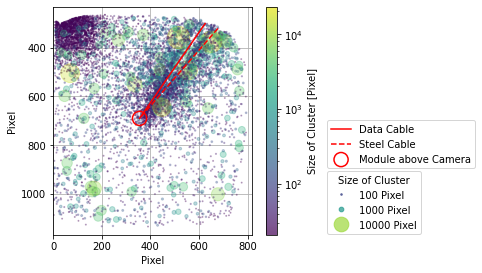

In [53]:
center_of_mass_y = df_no_led['center_of_mass_x'].to_numpy()
center_of_mass_x = df_no_led['center_of_mass_y'].to_numpy()

### Scatter plot ###
# def. linear norm function for marker size, maps [c.min(), c.max()] -> [s_min, s_max]
# min and max size of markers
s_min=1.
s_max=5e2
norm_size = scipy.interpolate.interp1d([df_no_led.n_pixel.min(), df_no_led.n_pixel.max()], [s_min, s_max])

# def. cmap, select one
#cmap=strawb.tools.cmap_manipulator('viridis_r', v_min=.03, v_max=1)  # v_min=.03 - cuts the yellow part
cmap=strawb.tools.cmap_manipulator('viridis', v_min=0, v_max=.97)  # v_max=.97 - cuts the yellow part
#cmap=strawb.tools.cmap_manipulator('Blues', v_min=.35, v_max=1)  #  v_min=.3 - cuts the white part


### PLOT
fig, ax = plt.subplots(figsize=(w, 3.9))
sc = plt.scatter(center_of_mass_x, center_of_mass_y, c=df_no_led.n_pixel, s=norm_size(df_no_led.n_pixel), 
                 cmap=cmap, norm=matplotlib.colors.LogNorm(),
                 alpha=.3)


plt.scatter(module_x, module_y, s=200, facecolors='none', edgecolors='red', 
            label='Module above Camera', linewidth=1.5) 
ax.plot([625, module_x], [300, module_y], 'r-', linewidth=1.5, label='Data Cable')
ax.plot([678, module_x], [320, module_y], 'r', linewidth=1.5, linestyle='--', label = 'Steel Cable')
ax.legend(loc='lower right', prop={'size':12})

legend1 = ax.legend(loc='lower left', bbox_to_anchor = (1.35, .27))
ax.add_artist(legend1)


# colorbar
cb = plt.colorbar(sc)
cb.set_label("Size of Cluster [Pixel]")
# make alpha different for the colorbar
cb.set_alpha(.7)
cb.draw_all()


### LEGEND START
# get the legend - maybe there is a better solution
num = matplotlib.ticker.LogLocator(numticks=6).tick_values(df_no_led.n_pixel.min(), df_no_led.n_pixel.max())

fmt = "{x:.0f} Pixel"
legends_c = sc.legend_elements(prop="colors", num=num, fmt=fmt, alpha=.7)


# generate the legend entries with color and size
# generation of legends_c_pos must match! sc.legend_elements(..., fmt,...)
fmt_e = fmt.split('{x')[1].split('}', 1)[1]
fmt_s = fmt.split('{x')[0]

legends_c_pos = np.array([i.replace(fmt_e, '').replace(fmt_s, '') for i in legends_c[1]], dtype=float)
legends_c_size = np.sqrt(norm_size(legends_c_pos))

for i, size_i in enumerate(legends_c_pos):
    legends_c[0][i].set_markersize(legends_c_size[i])


plt.legend(*legends_c, title="Size of Cluster", bbox_to_anchor=(1.35, -.018), loc='lower left')
### LEGEND DONE

plt.xlabel('Pixel')
plt.ylabel('Pixel')

#plt.xlim(0, 960)
#plt.ylim(1280, 0)
plt.xlim(0, 820)
plt.ylim(1170, 230)
ax.set_aspect('equal', 'box')

plt.grid()
plt.gca().set_axisbelow(True)  # move grid behind scatter plot
plt.tight_layout()
#plt.savefig('PMT001_center_of_mass.pdf', bbox_inches='tight')

In [177]:
min(list(df_fov.center_of_mass_x))

261.42758775900467

## Center of Pixels

/home/straw/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:1134: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


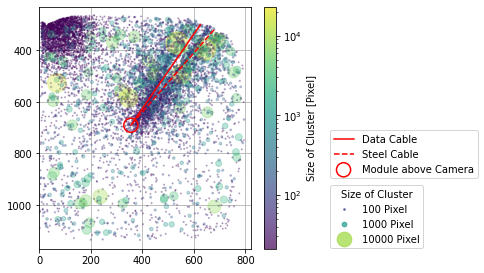

In [29]:
center_of_pix_y = df_no_led['center_of_pix_x'].to_numpy()
center_of_pix_x = df_no_led['center_of_pix_y'].to_numpy()

### Scatter plot ###
# def. linear norm function for marker size, maps [c.min(), c.max()] -> [s_min, s_max]
# min and max size of markers
s_min=1.
s_max=5e2
norm_size = scipy.interpolate.interp1d([df_no_led.n_pixel.min(), df_no_led.n_pixel.max()], [s_min, s_max])

# def. cmap, select one
#cmap=strawb.tools.cmap_manipulator('viridis_r', v_min=.03, v_max=1)  # v_min=.03 - cuts the yellow part
cmap=strawb.tools.cmap_manipulator('viridis', v_min=0, v_max=.97)  # v_max=.97 - cuts the yellow part
#cmap=strawb.tools.cmap_manipulator('Blues', v_min=.35, v_max=1)  #  v_min=.3 - cuts the white part


### PLOT
fig, ax = plt.subplots(figsize=(w, 3.9))
sc = plt.scatter(center_of_pix_x, center_of_pix_y, c=df_no_led.n_pixel, s=norm_size(df_no_led.n_pixel), 
                 cmap=cmap, norm=matplotlib.colors.LogNorm(),
                 alpha=.3)


plt.scatter(module_x, module_y, s=200, facecolors='none', edgecolors='red', 
            label='Module above Camera', linewidth=1.5) 
ax.plot([625, module_x], [300, module_y], 'r-', linewidth=1.5, label='Data Cable')
ax.plot([678, module_x], [320, module_y], 'r', linewidth=1.5, linestyle='--', label = 'Steel Cable')
ax.legend(loc='lower right', prop={'size':12})

legend1 = ax.legend(loc='lower left', bbox_to_anchor = (1.35, .27))
ax.add_artist(legend1)


# colorbar
cb = plt.colorbar(sc)
cb.set_label("Size of Cluster [Pixel]")
# make alpha different for the colorbar
cb.set_alpha(.7)
cb.draw_all()


### LEGEND START
# get the legend - maybe there is a better solution
num = matplotlib.ticker.LogLocator(numticks=6).tick_values(df_no_led.n_pixel.min(), df_no_led.n_pixel.max())

fmt = "{x:.0f} Pixel"
legends_c = sc.legend_elements(prop="colors", num=num, fmt=fmt, alpha=.7)


# generate the legend entries with color and size
# generation of legends_c_pos must match! sc.legend_elements(..., fmt,...)
fmt_e = fmt.split('{x')[1].split('}', 1)[1]
fmt_s = fmt.split('{x')[0]

legends_c_pos = np.array([i.replace(fmt_e, '').replace(fmt_s, '') for i in legends_c[1]], dtype=float)
legends_c_size = np.sqrt(norm_size(legends_c_pos))

for i, size_i in enumerate(legends_c_pos):
    legends_c[0][i].set_markersize(legends_c_size[i])


plt.legend(*legends_c, title="Size of Cluster", bbox_to_anchor=(1.35, -.018), loc='lower left')
### LEGEND DONE


plt.xlim(0, 820)
plt.ylim(1170, 230)
ax.set_aspect('equal', 'box')

plt.grid()
plt.gca().set_axisbelow(True)  # move grid behind scatter plot
plt.tight_layout()
#plt.savefig('PMT001_center_of_pix.pdf', bbox_inches='tight')

## Center of Minimum Bounding Boxes

/home/straw/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:1134: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


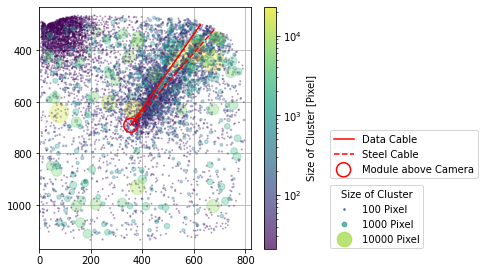

In [30]:
box_center_y = df_no_led['box_center_x'].to_numpy()
box_center_x = df_no_led['box_center_y'].to_numpy()

### Scatter plot ###
# def. linear norm function for marker size, maps [c.min(), c.max()] -> [s_min, s_max]
# min and max size of markers
s_min=1.
s_max=5e2
norm_size = scipy.interpolate.interp1d([df_no_led.n_pixel.min(), df_no_led.n_pixel.max()], [s_min, s_max])

# def. cmap, select one
#cmap=strawb.tools.cmap_manipulator('viridis_r', v_min=.03, v_max=1)  # v_min=.03 - cuts the yellow part
cmap=strawb.tools.cmap_manipulator('viridis', v_min=0, v_max=.97)  # v_max=.97 - cuts the yellow part
#cmap=strawb.tools.cmap_manipulator('Blues', v_min=.35, v_max=1)  #  v_min=.3 - cuts the white part


### PLOT
fig, ax = plt.subplots(figsize=(w, 3.9))
sc = plt.scatter(box_center_x, box_center_y, c=df_no_led.n_pixel, s=norm_size(df_no_led.n_pixel), 
                 cmap=cmap, norm=matplotlib.colors.LogNorm(),
                 alpha=.3)


plt.scatter(module_x, module_y, s=200, facecolors='none', edgecolors='red', 
            label='Module above Camera', linewidth=1.5) 
ax.plot([625, module_x], [300, module_y], 'r-', linewidth=1.5, label='Data Cable')
ax.plot([678, module_x], [320, module_y], 'r', linewidth=1.5, linestyle='--', label = 'Steel Cable')
ax.legend(loc='lower right', prop={'size':12})

legend1 = ax.legend(loc='lower left', bbox_to_anchor = (1.35, .27))
ax.add_artist(legend1)


# colorbar
cb = plt.colorbar(sc)
cb.set_label("Size of Cluster [Pixel]")
# make alpha different for the colorbar
cb.set_alpha(.7)
cb.draw_all()


### LEGEND START
# get the legend - maybe there is a better solution
num = matplotlib.ticker.LogLocator(numticks=6).tick_values(df_no_led.n_pixel.min(), df_no_led.n_pixel.max())

fmt = "{x:.0f} Pixel"
legends_c = sc.legend_elements(prop="colors", num=num, fmt=fmt, alpha=.7)


# generate the legend entries with color and size
# generation of legends_c_pos must match! sc.legend_elements(..., fmt,...)
fmt_e = fmt.split('{x')[1].split('}', 1)[1]
fmt_s = fmt.split('{x')[0]

legends_c_pos = np.array([i.replace(fmt_e, '').replace(fmt_s, '') for i in legends_c[1]], dtype=float)
legends_c_size = np.sqrt(norm_size(legends_c_pos))

for i, size_i in enumerate(legends_c_pos):
    legends_c[0][i].set_markersize(legends_c_size[i])


plt.legend(*legends_c, title="Size of Cluster", bbox_to_anchor=(1.35, -.018), loc='lower left')
### LEGEND DONE


plt.xlim(0, 820)
plt.ylim(1170, 230)
ax.set_aspect('equal', 'box')

plt.grid()
plt.gca().set_axisbelow(True)  # move grid behind scatter plot
plt.tight_layout()
#plt.savefig('PMT001_center_of_box.pdf', bbox_inches='tight')

-------------------------------------------------------------------------------------------------------------

### Center of Pixels and Minimum Bounding Box

/home/straw/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:1134: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


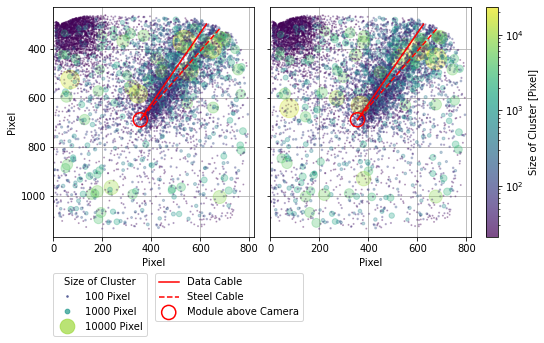

In [31]:
center_of_pix_y = df_no_led['center_of_pix_x'].to_numpy()
center_of_pix_x = df_no_led['center_of_pix_y'].to_numpy()

box_center_y = df_no_led['box_center_x'].to_numpy()
box_center_x = df_no_led['box_center_y'].to_numpy()

### Scatter plot ###
# def. linear norm function for marker size, maps [c.min(), c.max()] -> [s_min, s_max]
# min and max size of markers
s_min=1.
s_max=5e2
norm_size = scipy.interpolate.interp1d([df_no_led.n_pixel.min(), df_no_led.n_pixel.max()], [s_min, s_max])

# def. cmap, select one
#cmap=strawb.tools.cmap_manipulator('viridis_r', v_min=.03, v_max=1)  # v_min=.03 - cuts the yellow part
cmap=strawb.tools.cmap_manipulator('viridis', v_min=0, v_max=.97)  # v_max=.97 - cuts the yellow part
#cmap=strawb.tools.cmap_manipulator('Blues', v_min=.35, v_max=1)  #  v_min=.3 - cuts the white part


### PLOT
fig, ax = plt.subplots(1, 2, figsize=(1.5*w, 5), sharey=True)

plt.sca(ax[0])
sc = plt.scatter(center_of_pix_x, center_of_pix_y, c=df_no_led.n_pixel, s=norm_size(df_no_led.n_pixel), 
                 cmap=cmap, norm=matplotlib.colors.LogNorm(),
                 alpha=.3)


plt.scatter(module_x, module_y, s=200, facecolors='none', edgecolors='red', 
            label='Module above Camera', linewidth=1.5) 
ax[0].plot([625, module_x], [300, module_y], 'r-', linewidth=1.5, label='Data Cable')
ax[0].plot([678, module_x], [320, module_y], 'r', linewidth=1.5, linestyle='--', label = 'Steel Cable')
ax[0].legend(loc='lower right', prop={'size':12})

legend1 = ax[0].legend(loc='lower left', bbox_to_anchor = (.48, -.386))
ax[0].add_artist(legend1)



### LEGEND START
# get the legend - maybe there is a better solution
num = matplotlib.ticker.LogLocator(numticks=6).tick_values(df_no_led.n_pixel.min(), df_no_led.n_pixel.max())

fmt = "{x:.0f} Pixel"
legends_c = sc.legend_elements(prop="colors", num=num, fmt=fmt, alpha=.7)


# generate the legend entries with color and size
# generation of legends_c_pos must match! sc.legend_elements(..., fmt,...)
fmt_e = fmt.split('{x')[1].split('}', 1)[1]
fmt_s = fmt.split('{x')[0]

legends_c_pos = np.array([i.replace(fmt_e, '').replace(fmt_s, '') for i in legends_c[1]], dtype=float)
legends_c_size = np.sqrt(norm_size(legends_c_pos))

for i, size_i in enumerate(legends_c_pos):
    legends_c[0][i].set_markersize(legends_c_size[i])


plt.legend(*legends_c, title="Size of Cluster", bbox_to_anchor=(-.025, -.45), loc='lower left')


### LEGEND DONE
plt.xlim(0, 820)
plt.ylim(1170, 230)
ax[0].set_aspect('equal', 'box')

plt.grid()
plt.gca().set_axisbelow(True)  # move grid behind scatter plot
plt.tight_layout()

plt.xlabel('Pixel')
plt.ylabel('Pixel')


plt.sca(ax[1])
sc = plt.scatter(box_center_x, box_center_y, c=df_no_led.n_pixel, s=norm_size(df_no_led.n_pixel), 
                 cmap=cmap, norm=matplotlib.colors.LogNorm(),
                 alpha=.3)


plt.scatter(module_x, module_y, s=200, facecolors='none', edgecolors='red', 
            label='Module above Camera', linewidth=1.5) 
ax[1].plot([625, module_x], [300, module_y], 'r-', linewidth=1.5, label='Data Cable')
ax[1].plot([678, module_x], [320, module_y], 'r', linewidth=1.5, linestyle='--', label = 'Steel Cable')


# colorbar
cb = plt.colorbar(sc)
cb.set_label("Size of Cluster [Pixel]")
# make alpha different for the colorbar
cb.set_alpha(.7)
cb.draw_all()


plt.xlabel('Pixel')

plt.xlim(0, 820)
plt.ylim(1170, 230)
ax[1].set_aspect('equal', 'box')

plt.grid()
plt.gca().set_axisbelow(True)  # move grid behind scatter plot
plt.tight_layout()
fig.subplots_adjust(wspace=-.25)
#plt.savefig('PMT001_center_of_pixels_and_box.pdf', bbox_inches='tight')
plt.show()


## ----------------------------------------------------------------------------------------------------------

# Time Dependency

Histograms for the total number of pictures taken, the number of pictures with bioluminescent events on them and for the probability that a picture shows an event.

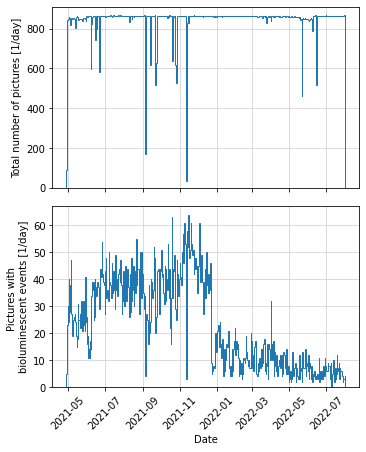

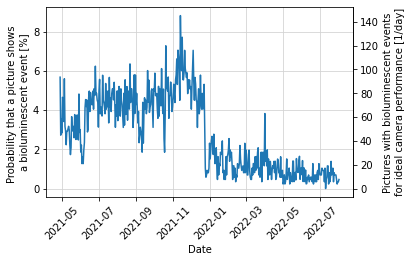

In [181]:
# define size of the bins

t_tot = pd.to_numeric(image_cluster_db.dataframe.time[~image_cluster_db.dataframe.time.isnull()]) * 1e-9 # convert to seconds

t_tot_u = np.unique(t_tot)
steps = 24*3600  # how many seconds are in one bin
t_start = t_tot_u[0] - t_tot_u[0] % steps # start the bins at midnight
t_end = t_tot_u[-1] - t_tot_u[-1] % steps + steps
bins = np.arange(t_start , t_end, steps)  # number of bins = number of days


# histogram of all pictures

counts_tot, bin_edges_tot = np.histogram(t_tot_u, bins=bins)
counts_tot = np.ma.masked_equal(counts_tot, 0)

date_edges = strawb.tools.asdatetime(bin_edges_tot)

fig, ax = plt.subplots(2, figsize=(w, 7), sharex=True)

#plt.figure(figsize=(w, 3.5))
plt.sca(ax[0])
plt.xticks(rotation=45)
plt.stairs(counts_tot, date_edges)
#plt.xlabel('Date')
plt.ylabel('Total number of pictures [1/day]')
plt.grid(color='lightgray')
plt.gca().set_axisbelow(True)
#plt.savefig('total_number_of_pictures.pdf', bbox_inches='tight')
#plt.show()


# histogram of pictures with animals

t = pd.to_numeric(df_i.time[mask_para][~image_cluster_db.dataframe.time.isnull()]) * 1e-9 # convert to seconds
t_u = np.unique(t)

counts, bin_edges = np.histogram(t_u, bins=bins)

#plt.figure(figsize=(w, 3.5))
plt.sca(ax[1])
plt.xticks(rotation=45)
plt.stairs(counts, date_edges)
plt.xlabel('Date')
plt.ylabel("""Pictures with 
bioluminescent events [1/day]""")
plt.grid(color='lightgray')
plt.gca().set_axisbelow(True)
fig.subplots_adjust(hspace=0.1)

#plt.savefig('number_of_pictures_with_animals.pdf', bbox_inches='tight')

plt.show()


p_animal = (counts/counts_tot)*100  # probability that a picture shows an animal

date = pd.to_datetime(strawb.tools.cal_middle(bin_edges)/(1e-9))

min_time = camera.file_handler.measured_capture_time[:].min() # minimal time needed for exposure + download 
theo_pix_min = (24*3600)/min_time  # maximal number of pictures per day


# probability that a picture shows an animal for each day

fig, ax = plt.subplots(figsize=(w, 3.5))
plt.xticks(rotation=45)
ax.plot(date, p_animal)
plt.xlabel('Date')
plt.ylabel("""Probability that a picture shows 
a bioluminescent event [%]""")

# number of pictures with animals per day if the camera was performing ideally and 
# there was no time needed for the download of the pictures

ax2 = ax.secondary_yaxis('right', 
                         functions = (lambda x: (x/100)* theo_pix_min * (min_time / camera.file_handler.exposure_time[:][0]),
                         lambda x: (x/100)/ (theo_pix_min * (min_time / camera.file_handler.exposure_time[:][0])) ))
ax2.set_ylabel("""Pictures with bioluminescent events
for ideal camera performance [1/day]""")
plt.grid(color='lightgray')
plt.gca().set_axisbelow(True)
#plt.savefig('probability_and_number_of_pictures_ideal.pdf', bbox_inches='tight')
plt.show()

## ----------------------------------------------------------------------------------------------------------

# Mounting

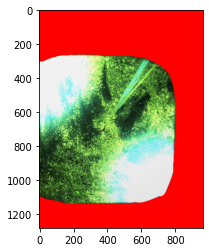

In [13]:
import matplotlib.image 
img = matplotlib.image.imread('TUMPMTSPECTROMETER001_mounting_mod.png')
imgplot = plt.imshow(img)
plt.show()

(array([[   0,    0],
        [   0,    1],
        [   0,    2],
        ...,
        [1279,  957],
        [1279,  958],
        [1279,  959]]),
 (566890, 2))

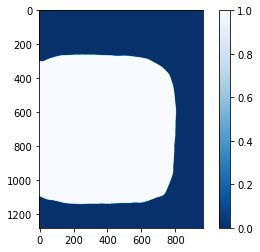

In [193]:
#with np.load('LED_imgs.npz') as f:
#    imgs = f['imgs']

#img = imgs[4]
blue = img[:,:,2]
green = img[:,:,1]
red = img[:,:,0]

mounting_blue = blue == 0
mounting_green = green == 0
mounting_red = red == 1

mounting = mounting_blue & mounting_green & mounting_red  

s = scipy.ndimage.generate_binary_structure(2,2)  

mounting_labeled, n = scipy.ndimage.measurements.label(mounting, structure=s)  

mask = mounting_labeled == mounting_labeled[-1]
mask = ~mask # invert the mask

mask_labeled, n_mask = scipy.ndimage.measurements.label(mask, structure=s)  

mask_area = scipy.ndimage.measurements.sum(mask, mask_labeled, index=np.arange(mask_labeled.max() + 1)) 

mask_size = mask_area[mask_labeled]  # set value of each pixel to the size of the cluster it belongs to 
m = np.where(mask_size == mask_area.max(), True, False)

plt.imshow(m, cmap='Blues_r')
plt.colorbar()

mounting_coo = np.argwhere(m == False) 
mounting_coo, mounting_coo.shape

In [15]:
m2 = ~m
m2

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

## ----------------------------------------------------------------------------------------------------------

# Time Dependency for PMT001 and PMT002

In [33]:
df_002 = pd.read_pickle('TUMPMTSPECTROMETER002_20210401T000000_20220901T000000_image_cluster_merge_npixel15.gz')


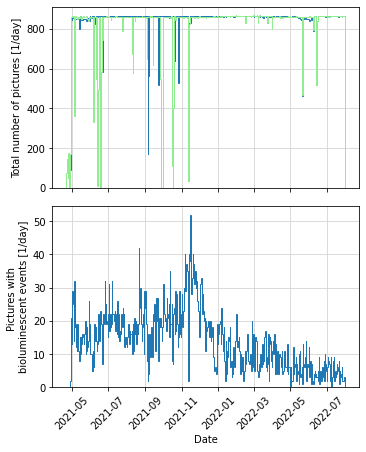

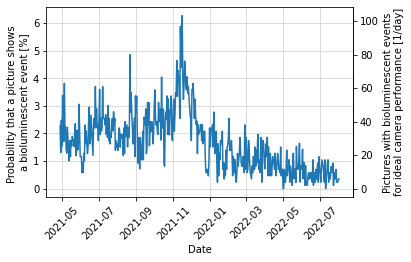

In [38]:
### PMT001
# define size of the bins

t_tot = pd.to_numeric(image_cluster_db.dataframe.time[~image_cluster_db.dataframe.time.isnull()]) * 1e-9 # convert to seconds

t_tot_u = np.unique(t_tot)
steps = 24*3600  # how many seconds are in one bin
t_start = t_tot_u[0] - t_tot_u[0] % steps # start the bins at midnight
t_end = t_tot_u[-1] - t_tot_u[-1] % steps + steps
bins = np.arange(t_start , t_end, steps)  # number of bins = number of days


### PMT002
# define size of the bins

t_tot002 = pd.to_numeric(df_002.time[~df_002.time.isnull()]) * 1e-9 # convert to seconds

t_tot002_u = np.unique(t_tot002)
t_start002 = t_tot002_u[0] - t_tot002_u[0] % steps # start the bins at midnight
t_end002 = t_tot002_u[-1] - t_tot002_u[-1] % steps + steps
bins002 = np.arange(t_start002 , t_end002, steps)  # number of bins = number of days


### PLOT
# histogram of all pictures

counts_tot, bin_edges_tot = np.histogram(t_tot_u, bins=bins)
counts_tot = np.ma.masked_equal(counts_tot, 0)
date_edges = strawb.tools.asdatetime(bin_edges_tot)

counts_tot002, bin_edges_tot002 = np.histogram(t_tot002_u, bins=bins002)
counts_tot002 = np.ma.masked_equal(counts_tot002, 0)
date_edges002 = strawb.tools.asdatetime(bin_edges_tot002)

fig, ax = plt.subplots(2, figsize=(w, 7), sharex=True)

plt.sca(ax[0])
plt.xticks(rotation=45)
plt.stairs(counts_tot, date_edges)
plt.stairs(counts_tot002, date_edges002, color='lightgreen')
plt.ylabel('Total number of pictures [1/day]')
plt.grid(color='lightgray')
plt.gca().set_axisbelow(True)



# histogram of pictures with animals

t = pd.to_numeric(df_no_led.time[mask_para][~image_cluster_db.dataframe.time.isnull()]) * 1e-9 # convert to seconds
t_u = np.unique(t)

counts, bin_edges = np.histogram(t_u, bins=bins)

#plt.figure(figsize=(w, 3.5))
plt.sca(ax[1])
plt.xticks(rotation=45)
plt.stairs(counts, date_edges)
plt.xlabel('Date')
plt.ylabel("""Pictures with 
bioluminescent events [1/day]""")
plt.grid(color='lightgray')
plt.gca().set_axisbelow(True)
fig.subplots_adjust(hspace=0.1)

#plt.savefig('number_of_pictures_with_animals.pdf', bbox_inches='tight')

plt.show()


p_animal = (counts/counts_tot)*100  # probability that a picture shows an animal

date = pd.to_datetime(strawb.tools.cal_middle(bin_edges)/(1e-9))

min_time = camera.file_handler.measured_capture_time[:].min() # minimal time needed for exposure + download 
theo_pix_min = (24*3600)/min_time  # maximal number of pictures per day


# probability that a picture shows an animal for each day

fig, ax = plt.subplots(figsize=(w, 3.5))
plt.xticks(rotation=45)
ax.plot(date, p_animal)
plt.xlabel('Date')
plt.ylabel("""Probability that a picture shows 
a bioluminescent event [%]""")

# number of pictures with animals per day if the camera was performing ideally and 
# there was no time needed for the download of the pictures

ax2 = ax.secondary_yaxis('right', 
                         functions = (lambda x: (x/100)* theo_pix_min * (min_time / camera.file_handler.exposure_time[:][0]),
                         lambda x: (x/100)/ (theo_pix_min * (min_time / camera.file_handler.exposure_time[:][0])) ))
ax2.set_ylabel("""Pictures with bioluminescent events
for ideal camera performance [1/day]""")
plt.grid(color='lightgray')
plt.gca().set_axisbelow(True)
#plt.savefig('probability_and_number_of_pictures_ideal.pdf', bbox_inches='tight')
plt.show()

## ----------------------------------------------------------------------------------------------------------